In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')


file_path = "/content/drive/MyDrive/T1.csv"
df = pd.read_csv(file_path)

df = df.rename(columns={
    'Date/Time': 'datetime',
    'LV ActivePower (kW)': 'power',
    'Wind Speed (m/s)': 'wind_speed',
    'Theoretical_Power_Curve (KWh)': 'theoretical_power',
    'Wind Direction (°)': 'wind_direction'
})

df['datetime'] = pd.to_datetime(df['datetime'], dayfirst=True)
df = df.sort_values('datetime')
df = df.set_index('datetime')

df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,power,wind_speed,theoretical_power,wind_direction
datetime,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [ ]:
#TASK 1

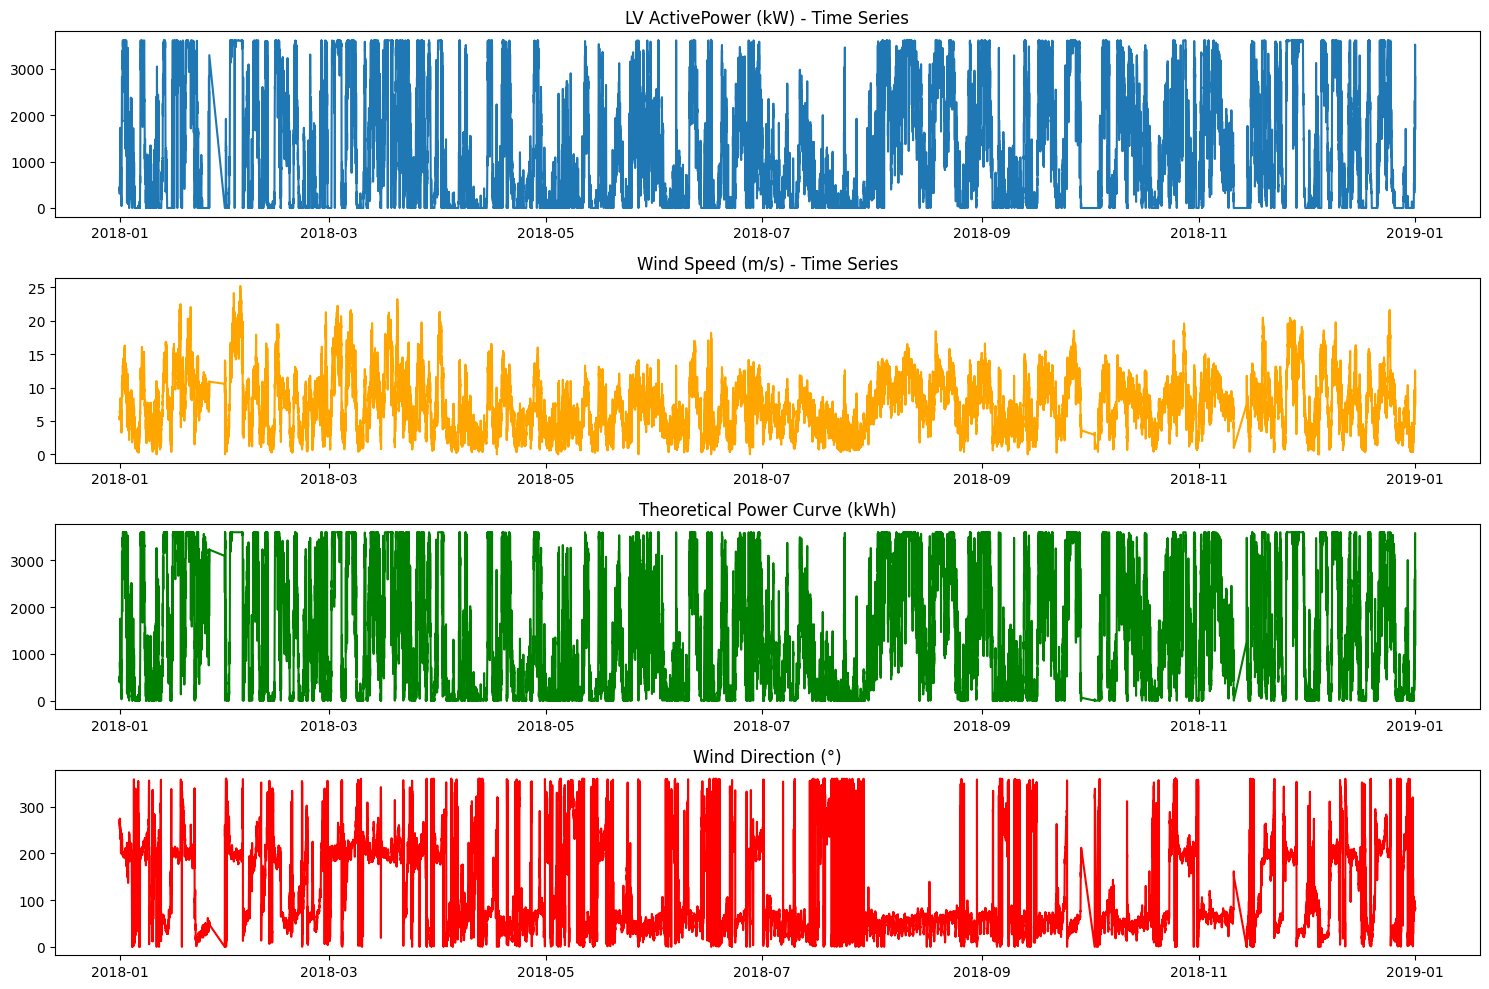

In [4]:
plt.figure(figsize=(15,10))

plt.subplot(4,1,1)
plt.plot(df.index, df['power'], label="Power")
plt.title("LV ActivePower (kW) - Time Series")

plt.subplot(4,1,2)
plt.plot(df.index, df['wind_speed'], label="Wind Speed", color="orange")
plt.title("Wind Speed (m/s) - Time Series")

plt.subplot(4,1,3)
plt.plot(df.index, df['theoretical_power'], label="Theoretical Power", color="green")
plt.title("Theoretical Power Curve (kWh)")

plt.subplot(4,1,4)
plt.plot(df.index, df['wind_direction'], label="Wind Direction", color="red")
plt.title("Wind Direction (°)")

plt.tight_layout()
plt.show()


In [5]:
print("Missing values:\n", df.isna().sum())


Missing values:
 power                0
wind_speed           0
theoretical_power    0
wind_direction       0
dtype: int64


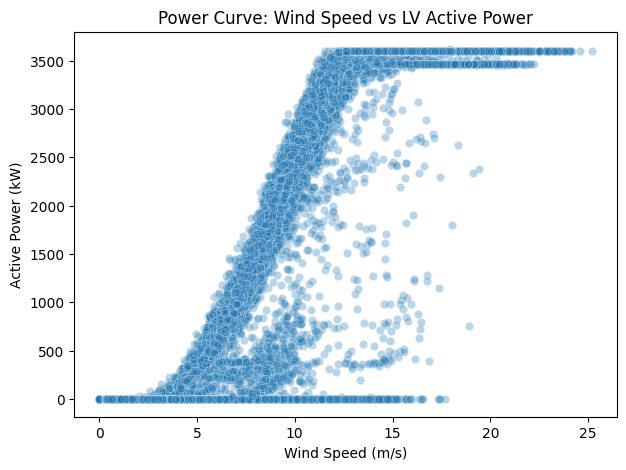

In [6]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=df['wind_speed'], y=df['power'], alpha=0.3)
plt.title("Power Curve: Wind Speed vs LV Active Power")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Active Power (kW)")
plt.show()


In [ ]:
#TASK 2

In [7]:
features = ['power', 'wind_speed', 'theoretical_power', 'wind_direction']
data = df[features].dropna()

scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled, index=data.index, columns=features)

def create_window_data(df, window=6):
    X, y = [], {col: [] for col in df.columns}
    for i in range(window, len(df)):
        X.append(df.iloc[i-window:i].values)
        for col in df.columns:
            y[col].append(df.iloc[i][col])
    return np.array(X), {col: np.array(vals) for col, vals in y.items()}

X, y_dict = create_window_data(scaled_df)


In [8]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]

y_train = {k: v[:split] for k, v in y_dict.items()}
y_test  = {k: v[split:] for k, v in y_dict.items()}


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

models = {}
preds = {}

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

for col in features:
    model = LinearRegression()
    model.fit(X_train_flat, y_train[col])
    pred = model.predict(X_test_flat)

    models[col] = model
    preds[col] = pred

    print(f"{col} -> MAE:", mean_absolute_error(y_test[col], pred))
    print(f"{col} -> RMSE:", np.sqrt(mean_squared_error(y_test[col], pred)))
    print("---------------------------------------------------")


power -> MAE: 0.03712484861118562
power -> RMSE: 0.06260153858581922
---------------------------------------------------
wind_speed -> MAE: 0.021169065984782767
wind_speed -> RMSE: 0.0292395547618284
---------------------------------------------------
theoretical_power -> MAE: 0.04554687922416605
theoretical_power -> RMSE: 0.07584275733566416
---------------------------------------------------
wind_direction -> MAE: 0.03221833762036701
wind_direction -> RMSE: 0.09963649426181266
---------------------------------------------------


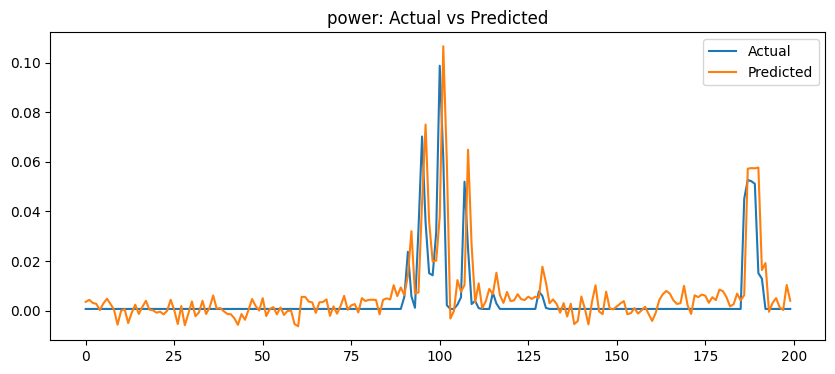

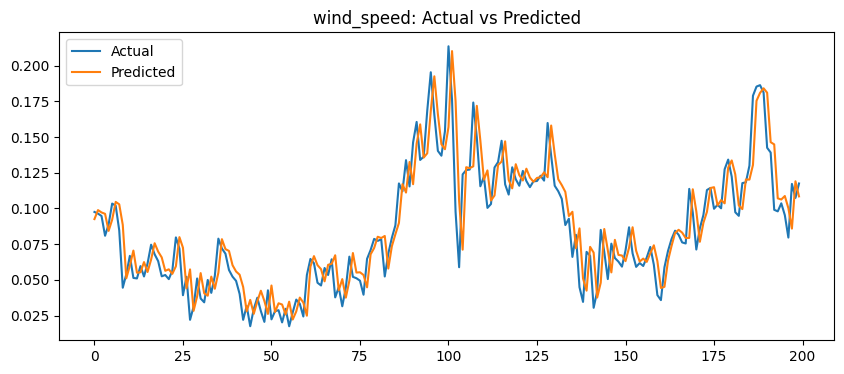

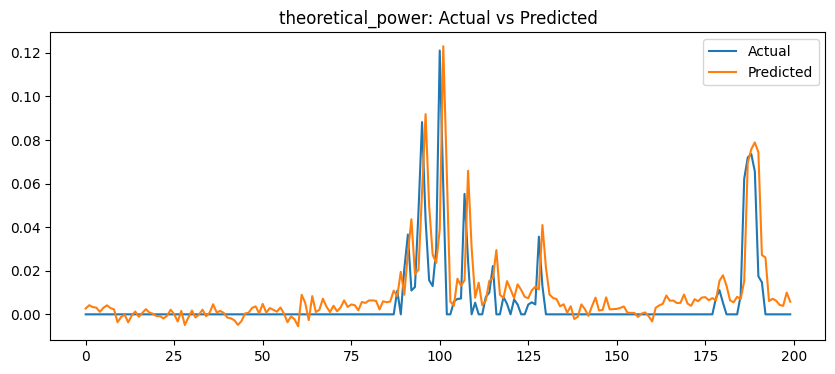

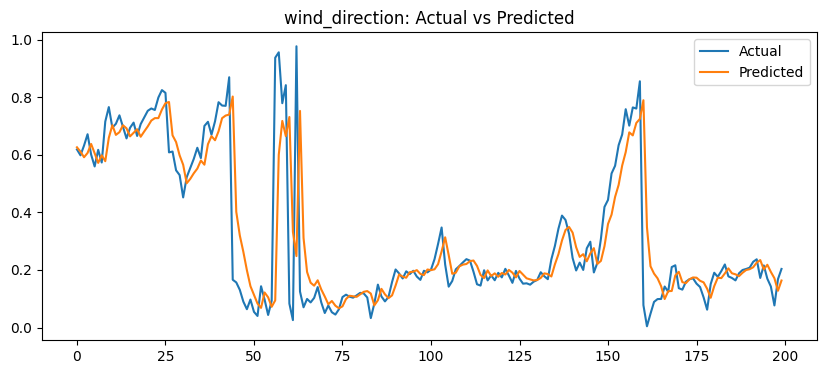

In [13]:
for col in features:
    plt.figure(figsize=(10,4))
    plt.plot(y_test[col][:200], label="Actual")
    plt.plot(preds[col][:200], label="Predicted")
    plt.title(f"{col}: Actual vs Predicted")
    plt.legend()
    plt.show()


In [ ]:
#TASK 3

Detected anomalies: 1011


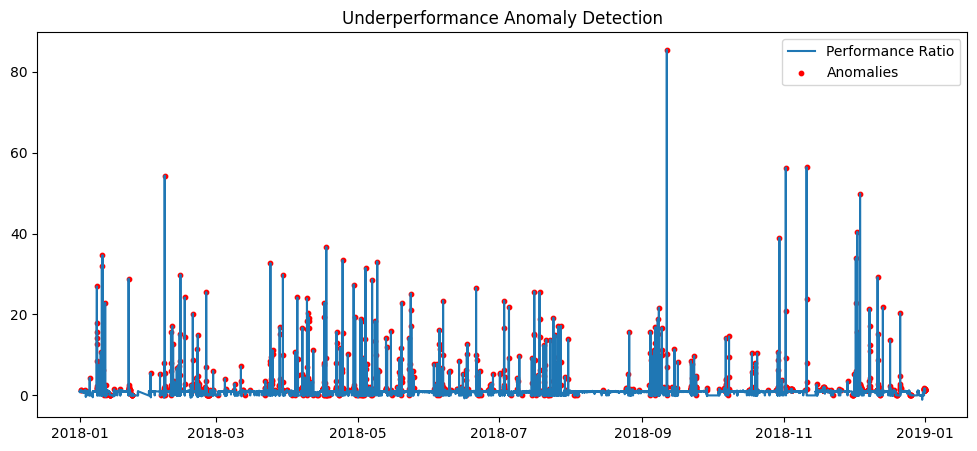

In [14]:
df['performance_ratio'] = df['power'] / (df['theoretical_power'] + 1)

iso = IsolationForest(contamination=0.02, random_state=42)
df['anomaly'] = iso.fit_predict(df[['performance_ratio']].fillna(0))

anomalies = df[df['anomaly'] == -1]
print("Detected anomalies:", anomalies.shape[0])

plt.figure(figsize=(12,5))
plt.plot(df.index, df['performance_ratio'], label="Performance Ratio")
plt.scatter(anomalies.index, anomalies['performance_ratio'], color='red', s=10, label="Anomalies")
plt.legend()
plt.title("Underperformance Anomaly Detection")
plt.show()


In [ ]:
#TASK 4

In [15]:
df['score'] = (df['power'] / (df['theoretical_power'] + 1)) * 100
df['score'] = df['score'].clip(0, 100)


In [16]:
def categorize(score):
    if score >= 70:
        return "Good"
    elif score >= 40:
        return "Moderate"
    else:
        return "Poor"

df['category'] = df['score'].apply(categorize)


In [17]:
def suggestion(cat):
    if cat == "Good":
        return "Turbine is operating efficiently. No action needed."
    elif cat == "Moderate":
        return "Turbine performance slightly low. Check for minor efficiency losses."
    else:
        return "Turbine underperforming. Inspect blades, gearbox or perform SCADA diagnostics."

df['suggestion'] = df['category'].apply(suggestion)


In [18]:
df[['power','theoretical_power','score','category','suggestion']].sample(5)


,power,theoretical_power,score,category,suggestion
datetime,,,,,
2018-06-20 14:50:00,2975.782959,3432.883076,86.659414,Good,Turbine is operating efficiently. No action ne...
2018-10-07 06:50:00,152.875000,159.625118,95.175027,Good,Turbine is operating efficiently. No action ne...
2018-08-21 07:40:00,1148.619995,1094.753330,100.000000,Good,Turbine is operating efficiently. No action ne...
2018-07-22 17:10:00,0.000000,18.079565,0.000000,Poor,"Turbine underperforming. Inspect blades, gearb..."
2018-07-09 08:10:00,0.000000,0.000000,0.000000,Poor,"Turbine underperforming. Inspect blades, gearb..."
